# Проект: Обучение с учителем. Качество модели

**Цель проекта:**  разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи проекта:**
Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
Нужно собрать данные по клиентам по следующим группам:
Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

market_file.csv - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца. Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

market_money.csv - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

market_time.csv - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

money.csv - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

In [1]:
!pip install numpy==1.22
!pip -q install phik
!pip install scikit-learn==1.1.3
!pip install shap -q
!pip install imbalanced-learn -q
#!pip install matplotlib==3.7.1 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score

In [4]:
from phik import phik_matrix

In [5]:
import shap

In [6]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Шаг 1. Загрузка данных
На данном этапе необходимо:
1. Загрузить предоставленные файлы;
2. Получить общую информацию по файлам и вывести каждый файл;
3. Сделать ввывод о данных, предоставленных в файлах.

In [7]:
market_file =  pd.read_csv ('/datasets/market_file.csv') 
market_money = pd.read_csv ('/datasets/market_money.csv') 
market_time = pd.read_csv ('/datasets/market_time.csv')
money = pd.read_csv ('/datasets/money.csv' , sep = ';' , decimal = ',' )

In [8]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [9]:
display(market_file.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [11]:
display(market_money.head())

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
display(market_time.head())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [14]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [15]:
display(money.head())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


# Вывод:
Все три датасета загрузулись без проблем из файлов. Разделителем строк оказалась запятая, но в файле money.csv это была точка с запятой.
Во всех датасетах необходимо изменить вид записи столбцов (русский редактор останется). Поменять тип данных в датасете market_file.
Также проверить на наличие дубликатов и пропусков.

## Шаг 2. Предобработка данных
На данном этапе работы с данными необходимо исправить замечания, установленные на шаге 1. А именно: переименовать столбцы, изменить тип данных и проверить на пропуски и дубликаты с дальнейшим их устранением, если такие есть.

### Работа с файлом market_file

In [16]:
market_file.columns = market_file.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
print(market_file.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')


In [17]:
#market_file.info()

In [18]:
market_file['маркет_актив_6_мес'] = market_file['маркет_актив_6_мес'].astype('float')

In [19]:
print (market_file['покупательская_активность'].unique())
print (market_file['тип_сервиса'].unique())
print (market_file['разрешить_сообщать'].unique())
print (market_file['популярная_категория'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [20]:
market_file['покупательская_активность'] = market_file['покупательская_активность'].str.replace('Снизилась', 'снизилась')
market_file['покупательская_активность'] = market_file['покупательская_активность'].str.replace('Прежний уровень', 'прежний_уровень')
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Товары для детей', 'товары_для_детей')
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Домашний текстиль', 'домашний_текстиль')
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Косметика и аксесуары', 'косметика_и_аксесуары')
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Техника для красоты и здоровья', 'техника_для_красоты_и_здоровья')
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Кухонная посуда', 'кухонная_посуда')
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Мелкая бытовая техника и электроника', 'мелкая_бытовая_техника')

In [21]:
print (market_file['покупательская_активность'].unique())
print (market_file['тип_сервиса'].unique())
print (market_file['разрешить_сообщать'].unique())
print (market_file['популярная_категория'].unique())

['снизилась' 'прежний_уровень']
['премиум' 'стандарт']
['да' 'нет']
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника']


In [22]:
print(market_file.isna().sum())

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64


In [23]:
print('Количество дубликатов строк в market_file :',market_file.duplicated().sum())

Количество дубликатов строк в market_file : 0


### Работа с файлом market_money

In [24]:
market_money.columns = market_money.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
print(market_money.columns)

Index(['id', 'период', 'выручка'], dtype='object')


In [25]:
market_money.info()
print (market_money['период'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [26]:
#market_money['период'] = market_money['период'].str.replace('препредыдущий_месяц', 'предыдущий_месяц')
#print (market_money['период'].unique())

In [27]:
print(market_money.isna().sum())

id         0
период     0
выручка    0
dtype: int64


In [28]:
print('Количество дубликатов строк в market_money :',market_money.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк',round(market_money.duplicated().sum() / market_money.shape[0]* 100,1))

Количество дубликатов строк в market_money : 0
Процент дубликатов строк от всего количества строк 0.0


In [29]:
#market_money = market_money.drop_duplicates().reset_index(drop = True)
#print('Количество дубликатов строк в market_money :',market_money.duplicated().sum())

### Работа с файлом market_time

In [30]:
market_time.columns = market_time.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
print(market_time.columns)

Index(['id', 'период', 'минут'], dtype='object')


In [31]:
market_time = market_time.rename(
    columns ={'минут' : 'минуты'})
print(market_time.columns)

Index(['id', 'период', 'минуты'], dtype='object')


In [32]:
#market_time.info()
print (market_time['период'].unique())

['текущий_месяц' 'предыдцщий_месяц']


In [33]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
print (market_time['период'].unique())

['текущий_месяц' 'предыдущий_месяц']


In [34]:
print(market_time.isna().sum())

id        0
период    0
минуты    0
dtype: int64


In [35]:
print('Количество дубликатов строк в market_time :',market_time.duplicated().sum())

Количество дубликатов строк в market_time : 0


### Работа с файлом money

In [36]:
money.columns = money.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
print(money.columns)

Index(['id', 'прибыль'], dtype='object')


In [37]:
print(market_time.isna().sum())

id        0
период    0
минуты    0
dtype: int64


In [38]:
print('Количество дубликатов строк в money :',money.duplicated().sum())

Количество дубликатов строк в money : 0


# Вывод
Была проведена предобработка данных.
Во всех файлах была проведена редакция названия колон.
Во всех файлах были проверены данные на уникальноть, если наблюдались несоответсвия - они исправлялись.
Всех файлах отсутствуют пропуски.
Во всех данных дубликаты отсутствовали.

## Шаг 3. Исследовательский анализ данных
На данном этапе необходимо провести исследовательский анализ данных из каждой таблицы и Отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 

### Работа с файлом market_file

In [39]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

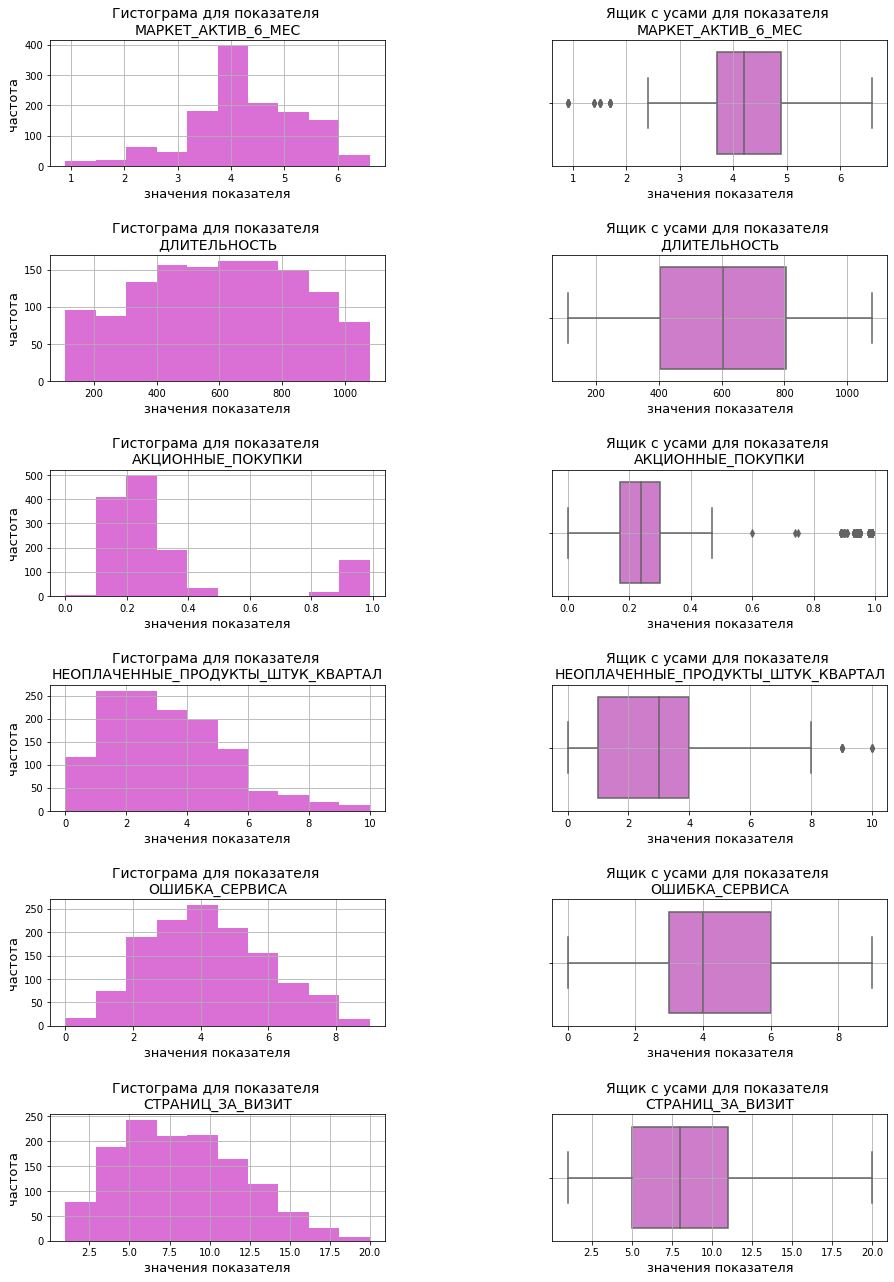

In [40]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит' 
]

for name in list:
    position += 1
    
    df1 = market_file[name]
    name = list[list.index(name)]
    plt.subplot(8, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = market_file[name]
    name = list[list.index(name)]
    plt.subplot(8, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

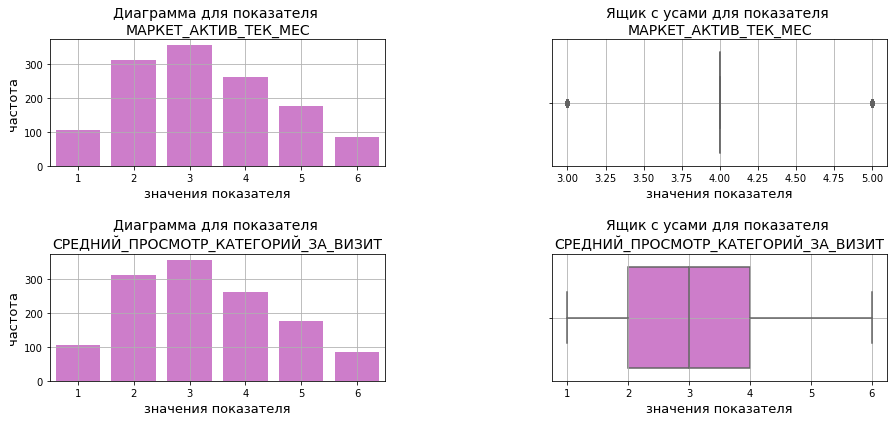

In [41]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит'
]

for name in list:
    position += 1
    
    df1 = market_file[name]
    name = list[list.index(name)]
    plt.subplot(8, 2, position)
    sns.countplot(x ='средний_просмотр_категорий_за_визит', data = market_file, color = 'orchid')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = market_file[name]
    name = list[list.index(name)]
    plt.subplot(8, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [42]:
display(market_file.query('маркет_актив_6_мес < 2'))

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
30,215378,снизилась,стандарт,да,1.7,3,488,0.39,техника_для_красоты_и_здоровья,5,1,4,3
32,215380,снизилась,премиум,нет,1.7,4,637,0.94,техника_для_красоты_и_здоровья,3,2,4,7
38,215386,снизилась,стандарт,да,1.5,3,495,0.98,домашний_текстиль,2,3,7,5
47,215395,снизилась,премиум,да,1.5,5,645,0.27,товары_для_детей,3,3,6,5
55,215403,снизилась,премиум,да,1.7,5,771,0.39,техника_для_красоты_и_здоровья,1,8,2,5
61,215409,снизилась,премиум,да,1.4,4,857,0.95,кухонная_посуда,3,4,5,5
63,215411,снизилась,стандарт,да,1.7,4,756,0.33,товары_для_детей,2,3,7,4
70,215418,снизилась,стандарт,нет,1.7,4,472,0.94,домашний_текстиль,2,6,4,3
81,215429,снизилась,премиум,нет,0.9,4,690,0.24,домашний_текстиль,2,5,7,4
108,215456,снизилась,стандарт,да,1.7,4,449,0.23,косметика_и_аксесуары,3,4,4,5


In [43]:
display(market_file.query('неоплаченные_продукты_штук_квартал > 8'))

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
72,215420,снизилась,стандарт,да,3.5,5,449,0.35,домашний_текстиль,1,9,2,2
73,215421,снизилась,премиум,нет,4.0,5,523,0.94,техника_для_красоты_и_здоровья,1,10,7,5
117,215465,снизилась,стандарт,да,3.5,5,449,0.28,домашний_текстиль,1,9,2,2
118,215466,снизилась,премиум,нет,2.4,5,523,0.30,техника_для_красоты_и_здоровья,1,10,1,4
176,215524,снизилась,стандарт,да,3.0,3,474,0.23,техника_для_красоты_и_здоровья,1,10,4,2
186,215534,снизилась,премиум,нет,4.0,4,419,0.93,товары_для_детей,1,9,3,3
204,215552,снизилась,стандарт,да,0.9,4,624,0.89,косметика_и_аксесуары,1,9,5,1
216,215564,снизилась,стандарт,нет,3.9,3,618,0.24,техника_для_красоты_и_здоровья,2,10,3,5
246,215594,снизилась,стандарт,да,4.2,4,627,0.90,товары_для_детей,6,9,5,8
251,215599,снизилась,стандарт,да,3.4,4,716,0.28,домашний_текстиль,2,9,4,6


In [44]:
list = [ 
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит' 
]

for name in list:
    df1 = market_file[name]
    name = list[list.index(name)]
    print(f'Характеристики количественного показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя МАРКЕТ_АКТИВ_6_МЕС
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64 

Характеристики количественного показателя МАРКЕТ_АКТИВ_ТЕК_МЕС
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64 

Характеристики количественного показателя ДЛИТЕЛЬНОСТЬ
count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64 

Характеристики количественного показателя АКЦИОННЫЕ_ПОКУПКИ
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%   

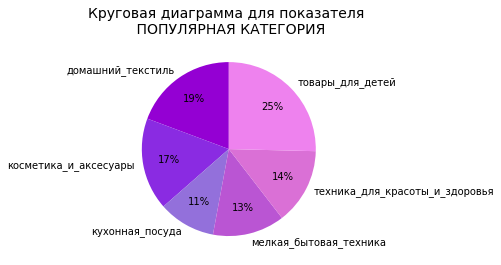

In [45]:
df1 = market_file.pivot_table(index = 'популярная_категория', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=[ 'darkviolet', 'blueviolet', 'mediumpurple', 'mediumorchid', 'orchid', 'violet']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма для показателя \n ПОПУЛЯРНАЯ КАТЕГОРИЯ', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

В датафрейме market_file:
- покупательская_активность снизилась у 38% клиентов. это плохой показатель, необходимо выяснить причину.
- тип_сервиса стандартный у 71% клиентов. Премиумом ползуются 29%. Хорощий показатель.
- разрешить_сообщать. 74% клиентов соглашаются на рассылку товаров. Возможно такой большой процент вызван из-за предоставления, например, скидки.
- Распределение популярных категорий выглядит следующим образом:
  - товары для детей: 25%
  - товары для дома 19%
  - косметика и аксессуары 17%
  - техника для красоты и здоровья 14%
  - мелкая бытовая техника 13%
  - кухонная посуда 11%
- Маркетинговая_активность в текущий месяц у большинства клиентов составляет 4 штуки.
- Исследовав данные по маркетинговой активности за 6 месяцев, видно, что покупательская активность держится лучше у тех, кто переключается на маркетинговые активы, развивается более 4-х раз за полгода, так же как и на коробках импульсов тех, кто менее 2,4-х раз попадает на маркетинговую коммуникацию. Если глянуть список, то видно, что почти все они менее активные покупатели.
- По данным столбца длительности заметно, что то, как давно клиент зарегестрирован, не говорит о том, что он будет более активным. 
- По данным акционных покупок замечено, что они приобретают товары невзирая на скидки, сохраняя свою активность. А вот те, кто покупает со скидками, не особо активны.
- По данным неоплаченных товаров в корзине за квартал, видно, что менее заинтерсованных покупателей в корзине лежат гораздо больше товаров. Активная аудитория имеет не более 5 товаров. Неактивная же любит положить в корзину побольше
- Сайт часто падает, люди ловят по 2-4 ошибки выезда из сервиса.
- Про страницы: чем меньше категорий посещаемости клиентов, тем больше вероятность, что он не будет закупаться постоянно.

### Работа с файлом market_money

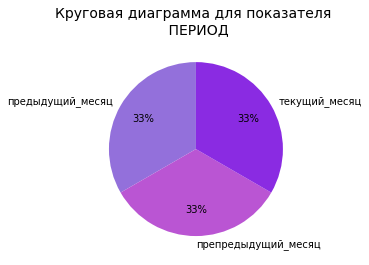

In [46]:
df1 = market_money.pivot_table(index = 'период', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=['mediumpurple', 'mediumorchid', 'blueviolet']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма для показателя \n ПЕРИОД', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

In [47]:
money_period = market_money.pivot_table(index='период', values=['выручка'], aggfunc='sum').reset_index()
display(money_period)

,период,выручка
0,предыдущий_месяц,6417996.5
1,препредыдущий_месяц,6272769.0
2,текущий_месяц,6909449.1


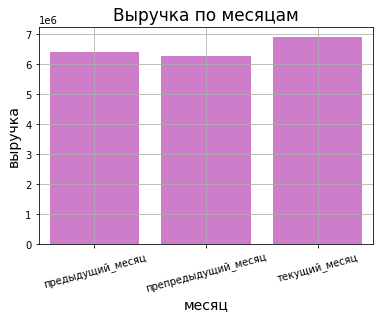

In [48]:
sns.barplot(x='период', y='выручка', data=money_period,color ='orchid')
plt.grid(True)
plt.title('Выручка по месяцам', fontsize=17);
plt.xlabel('месяц', fontsize=14);
plt.ylabel('выручка',fontsize=14);
plt.xticks(rotation=15)
plt.show()

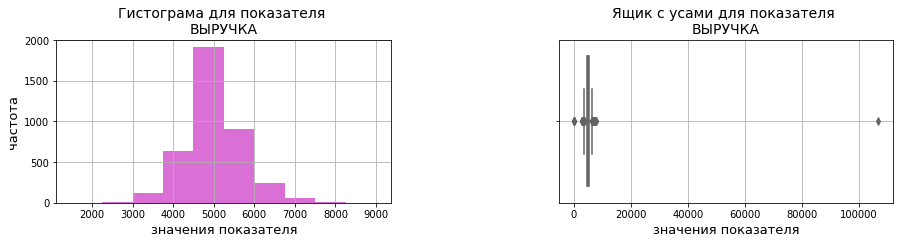

In [49]:
position = 0
plt.figure(figsize=[15,3])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'выручка' 
]

for name in list:
    position += 1
    
    df1 = market_money[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    df1.plot(kind = 'hist', color = 'orchid', range = (1500,9000))
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = market_money[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [50]:
display(market_money.query('выручка > 100000'))

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [51]:
market_money= market_money[market_money['выручка']<100000]

In [52]:
display(market_money.query('выручка == 0'))

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [53]:
market_money = market_money[market_money['выручка'] > 0]

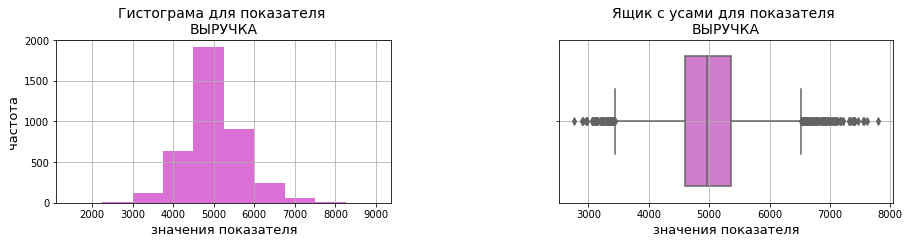

In [54]:
position = 0
plt.figure(figsize=[15,3])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'выручка' 
]

for name in list:
    position += 1
    
    df1 = market_money[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    df1.plot(kind = 'hist', color = 'orchid', range = (1500,9000))
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = market_money[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [55]:
print(f'Характеристика количественного показателя ВЫРУЧКА')
print(market_money['выручка'].describe(),'\n')

Характеристика количественного показателя ВЫРУЧКА
count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64 



В датафрейме market_money:
- Распределение покупок по месяцам одинаковое
- Выручка от месяца к месяцу растет, не снижая активности. 6272769 в препредыдущем; затем 6417996 в предыдущем и выше 6909449 в текущем месяце.
- Есть какой-то клиент, который купил товар более, чем за 100 000.
- Чаще всего клиенты тратят 5 000, а все что меньше 3 500 или больше 6 500 уже выбивается из межквартильного размаха. Был убран 1 выброс, с выручкой более, чем 100 000.

### Работа с файлом market_time

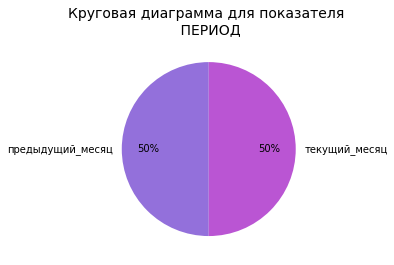

In [56]:
df1 = market_time.pivot_table(index = 'период', values = 'id', aggfunc = 'count')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.0f%%'
    ,colors=['mediumpurple', 'mediumorchid']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма для показателя \n ПЕРИОД', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

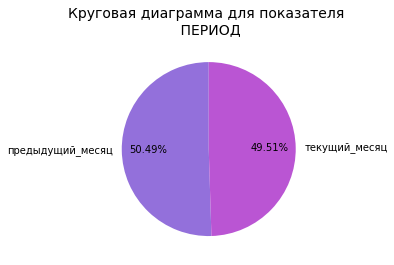

In [57]:
df1 = market_time.pivot_table(index = 'период', values = 'минуты', aggfunc = 'sum')
df1.plot(
    kind = 'pie'
    ,subplots=True
    ,autopct='%.2f%%'
    ,colors=['mediumpurple', 'mediumorchid']
    ,startangle=90
    ,pctdistance=0.7);
plt.title(f'Круговая диаграмма для показателя \n ПЕРИОД', fontsize=14);
plt.ylabel("");
plt.legend().remove();
plt.show();

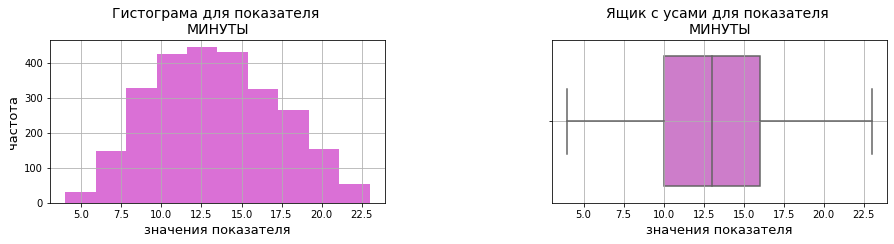

In [58]:
position = 0
plt.figure(figsize=[15,3])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'минуты' 
]

for name in list:
    position += 1
    
    df1 = market_time[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = market_time[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [59]:
time_period = market_time.pivot_table(index='период', values=['минуты'], aggfunc='sum').reset_index()
display(time_period)

,период,минуты
0,предыдущий_месяц,17508
1,текущий_месяц,17166


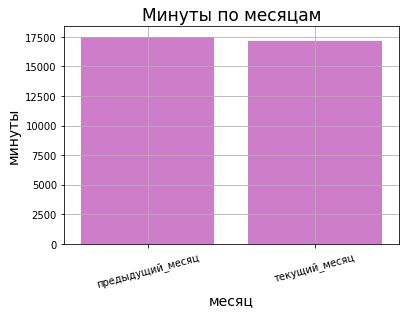

In [60]:
sns.barplot(x='период', y='минуты', data=time_period,color ='orchid')
plt.grid(True)
plt.title('Минуты по месяцам', fontsize=17);
plt.xlabel('месяц', fontsize=14);
plt.ylabel('минуты',fontsize=14);
plt.xticks(rotation=15)
plt.show()

В датафрейме market_time:
- Время посещения для каждого месяца в среднем проводят одинаково.

### Работа с файлом money

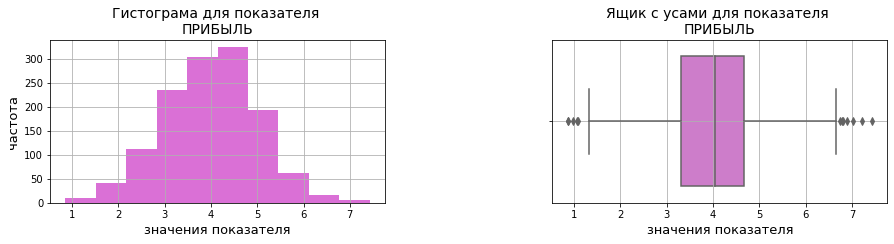

In [61]:
position = 0
plt.figure(figsize=[15,3])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'прибыль' 
]

for name in list:
    position += 1
    
    df1 = money[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = money[name]
    name = list[list.index(name)]
    plt.subplot(1, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

В датафрейме money:
- Значение прибыли имеет нормальное распределение, на ящике виднеются выбросы, похожи на те, что есть и в датасете выше по выручке.

In [62]:
len(market_file)

1300

In [63]:
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market_file = market_file[market_file['id'].isin(grouped.index)]
len(market_file)

1296

# Вывод:

В датафрейме market_file:
- покупательская_активность снизилась у 38% клиентов. это плохой показатель, необходимо выяснить причину.
- тип_сервиса стандартный у 71% клиентов. Премиумом ползуются 29%. Хорощий показатель.
- разрешить_сообщать. 74% клиентов соглашаются на рассылку товаров. Возможно такой большой процент вызван из-за предоставления, например, скидки.
- Распределение популярных категорий выглядит следующим образом:
  - товары для детей: 25%
  - товары для дома 19%
  - косметика и аксессуары 17%
  - техника для красоты и здоровья 14%
  - мелкая бытовая техника 13%
  - кухонная посуда 11%
- Маркетинговая_активность в текущий месяц у большинства клиентов составляет 4 штуки.
- Исследовав данные по маркетинговой активности за 6 месяцев, видно, что покупательская активность держится лучше у тех, кто переключается на маркетинговые активы, развивается более 4-х раз за полгода, так же как и на коробках импульсов тех, кто менее 2,4-х раз попадает на маркетинговую коммуникацию. Если глянуть список, то видно, что почти все они менее активные покупатели.
- По данным столбца длительности заметно, что то, как давно клиент зарегестрирован, не говорит о том, что он будет более активным. 
- По данным акционных покупок замечено, что они приобретают товары невзирая на скидки, сохраняя свою активность. А вот те, кто покупает со скидками, не особо активны.
- По данным неоплаченных товаров в корзине за квартал, видно, что менее заинтерсованных покупателей в корзине лежат гораздо больше товаров. Активная аудитория имеет не более 5 товаров. Неактивная же любит положить в корзину побольше
- Сайт часто падает, люди ловят по 2-4 ошибки выезда из сервиса.
- Про страницы: чем меньше категорий посещаемости клиентов, тем больше вероятность, что он не будет закупаться постоянно.

В датафрейме market_money:
- Распределение покупок по месяцам одинаковое
- Выручка от месяца к месяцу растет, не снижая активности. 6272769 в препредыдущем; затем 6417996 в предыдущем и выше 6909449 в текущем месяце.
- Есть какой-то клиент, который купил товар более, чем за 100 000.
- Чаще всего клиенты тратят 5 000, а все что меньше 3 500 или больше 6 500 уже выбивается из межквартильного размаха. Был убран 1 выброс, с выручкой более, чем 100 000.

В датафрейме market_time:
- Время посещения для каждого месяца в среднем проводят одинаково.

В датафрейме money:
- Значение прибыли имеет нормальное распределение, на ящике виднеются выбросы, похожи на те, что есть и в датасете выше по выручке.

## Шаг 4. Объединение таблиц

In [64]:
market_money['выручка_текущий_месяц'] = market_money.loc[market_money['период'] == 'текущий_месяц', 'выручка']
market_money['выручка_предыдущий_месяц'] = market_money.loc[market_money['период'] == 'предыдущий_месяц', 'выручка']   
market_money['выручка_препредыдущий_месяц'] = market_money.loc[market_money['период'] == 'препредыдущий_месяц', 'выручка']   
drop_columns=['период', 'выручка']
market_money= market_money.drop(drop_columns, axis =1)
market_money = market_money.groupby('id') .agg ({'выручка_текущий_месяц':'first', 'выручка_предыдущий_месяц':'first',
                                                 'выручка_препредыдущий_месяц':'first' })
display(market_money.head(5))

,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц
id,,,
215348,3293.1,NaN,NaN
215349,4971.6,5216.0,4472.0
215350,5058.4,5457.5,4826.0
215351,6610.4,6158.0,4793.0
215352,5872.5,5807.5,4594.0


In [65]:
market_time['период_текущий_месяц'] = market_time.loc[market_time['период'] == 'текущий_месяц', 'минуты']
market_time['период_предыдущий_месяц'] = market_time.loc[market_time['период'] == 'предыдущий_месяц', 'минуты']
drop_columns=['период', 'минуты']
market_time= market_time.drop(drop_columns, axis =1)
market_time = market_time.groupby('id') .agg ({'период_текущий_месяц':'first', 'период_предыдущий_месяц':'first'})
display(market_time.head(5))

,период_текущий_месяц,период_предыдущий_месяц
id,,
215348,14.0,13.0
215349,10.0,12.0
215350,13.0,8.0
215351,13.0,11.0
215352,11.0,8.0


In [66]:
market_full = pd.merge(pd.merge(market_file, market_money, on='id'), market_time, on='id')
display(market_full.head(5))

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,период_текущий_месяц,период_предыдущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4971.6,5216.0,4472.0,10.0,12.0
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5058.4,5457.5,4826.0,13.0,8.0
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6610.4,6158.0,4793.0,13.0,11.0
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5872.5,5807.5,4594.0,11.0,8.0
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5388.5,4738.5,5124.0,10.0,10.0


# Вывод
Было проведено обьединение таблицы для дальнейшей работы с данными.

## Шаг 5. Корреляционный анализ
Необходимо провести корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделать выводы о мультиколлинеарности и при необходимости устранить её.

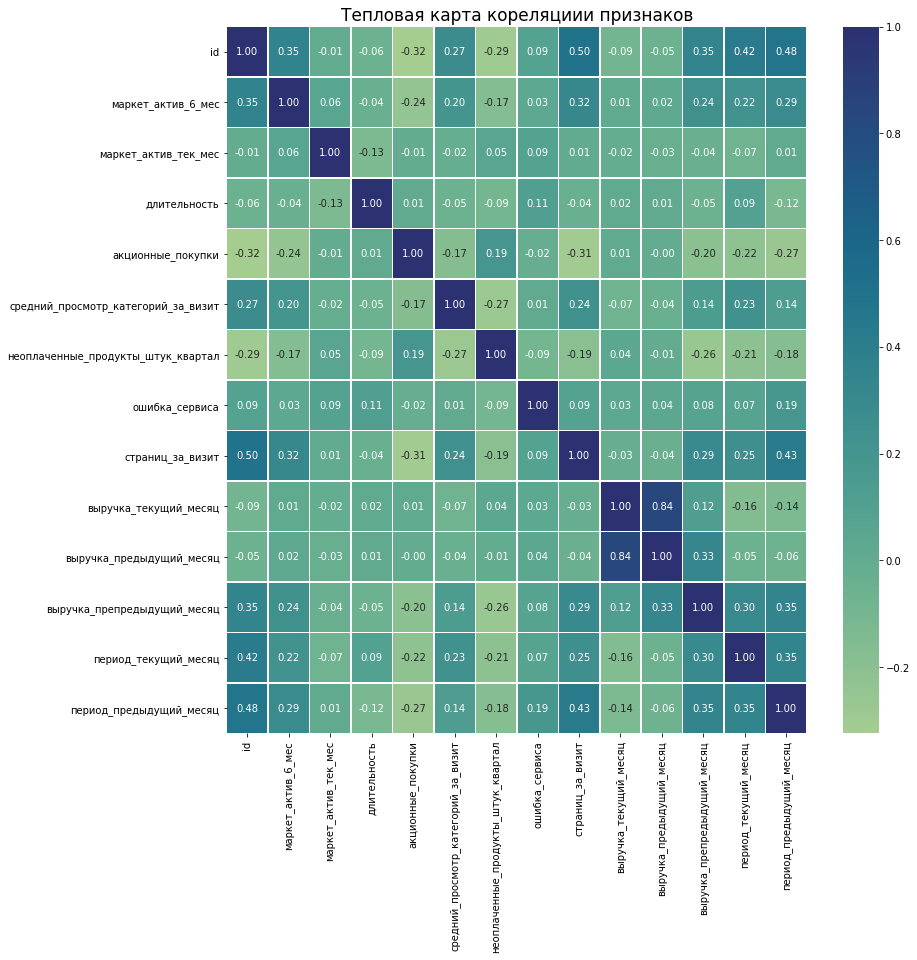

In [67]:
plt.figure(figsize=(13, 13));
sns.heatmap(
    market_full.corr()
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'период_текущий_месяц', 'период_предыдущий_месяц']


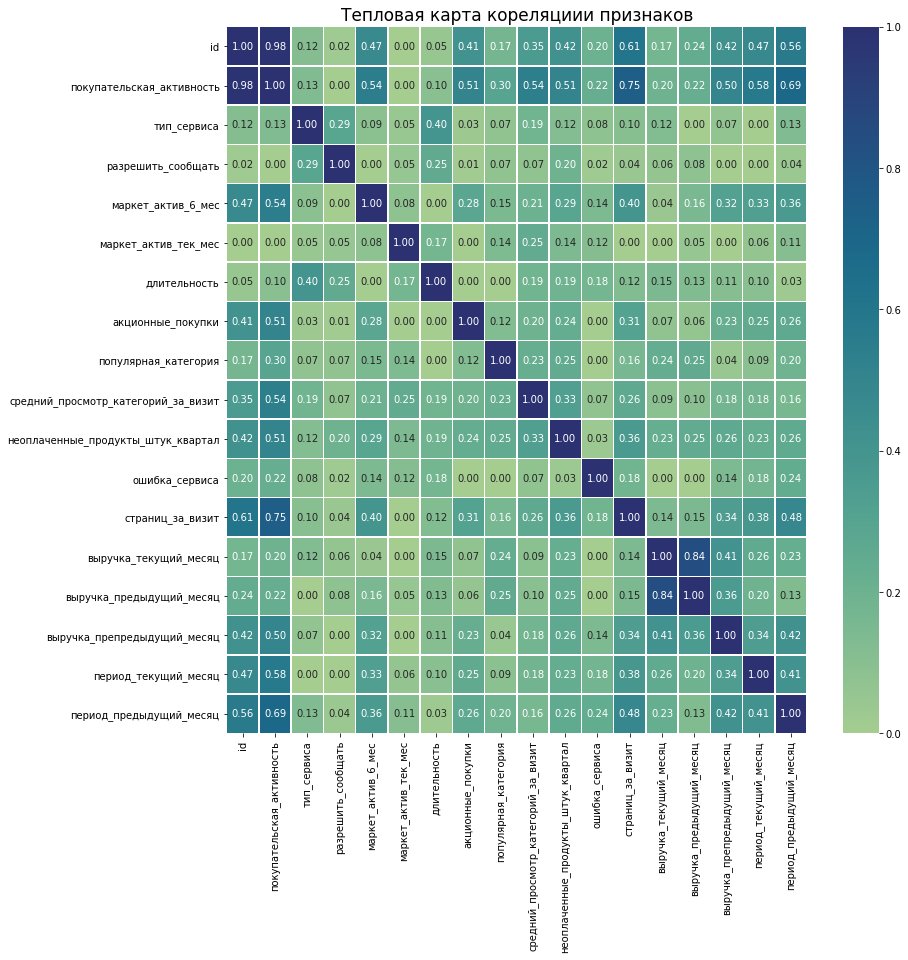

In [68]:
plt.figure(figsize=(13, 13));
sns.heatmap(
    market_full.phik_matrix()
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

# Вывод

Целевой признак - Покупательская_активность.

Список признаков, которые имеют корреляцию с целевым: 
- Маркет_актив_6_мес, 
- Акционные_покупки, 
- Средний_просмотр_категорий_за_визит, 
- Неоплаченные_продукты_штук_квартал, 
- Страниц_за_визит, 
- Выручка_препредыдущий_месяц, 
- минут_предыдущий_месяц, 
- минут_текущий_месяц.

Среди признаков сильная корреляция: Страниц_за_визит, минут_предыдущий_месяц.

Но значение корреляции меньше 0.9 поэтому не будем удалять признаки.



## Шаг 6. Использование пайплайнов
Для решения поставленной задачи необходимо:
1. Проверить данные на необходимость стратификации
2. Провести необходимую подготовку данных
3. Обучить четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()
4. Выбрать лучшую модель

### Подготовка данных перед обучением

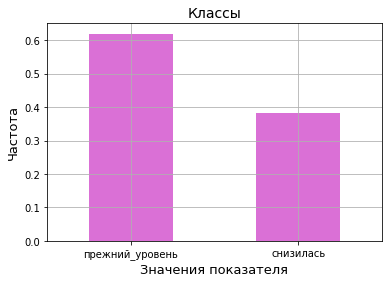

In [69]:
market_full['покупательская_активность'].value_counts(normalize=True).plot(kind='bar', color = 'orchid')
plt.title('Классы',fontsize=14)
plt.xlabel('Значения показателя', fontsize=13)
plt.ylabel('Частота', fontsize=13)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### Вывод
Датасет разбит в пропорции, приблизительно 2:1:
- Мажорный класс - прежний_уровень;
- Минорный класс - снизилась.

Перед созданием моделей необходимо провести стратификацию данных.

### Создание пайплайнов

In [70]:
X = market_full.drop(['покупательская_активность', 'id'], axis=1)
y= market_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [71]:
print(market_full.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'период_текущий_месяц',
       'период_предыдущий_месяц'],
      dtype='object')


In [72]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес','длительность',
               'акционные_покупки','средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал'
               ,'ошибка_сервиса','страниц_за_визит','выручка_текущий_месяц', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'период_текущий_месяц',
       'период_предыдущий_месяц']

In [73]:
ohe_pipe = Pipeline(
    [
        (
           'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
        'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)#, sparse=False)
        )
    ]
)

In [74]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
             OrdinalEncoder(
                 categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [75]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

###  Обучение на четырех моделях: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Выбор лучшей модели

In [76]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [77]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2,7),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     #словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,kernel='poly', probability=True)],
        'models__degree': range(2, 5),
        'models__C': np.logspace(-2, 2, 5),
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [78]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [79]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_bef...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(C=10.0, degree=2,
                                                        gamma='auto',
                                                        kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                         'models__degree': range(2, 5),
                                         'models__gamma': ['scale', 'auto'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

 


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


  

- Полезно замерить время исполнения кода в самых тяжёлых ячейке, это можно сделать с помощью магической функции %%time или библиотеки time. И тогда коллеге работающие с твоим кодом будут ориентироваться сколько займёт время обучение модели. И стоит ждать или можно попить чайку )
    
           
- можно разговорить модельку с помощью подачи verbose = 3, а чтобы выводилось не только метрика   по которой ты подбираешь гиперпараметры, но целый список из метрик (может  добавить scoring=['Метрика', '', ''...], а через refit   указать по какой метрике подбираются гиперпараметры ). Полезно чтобы получить общее представление, ведь нет какой-то универсальной метрики     
     
    

In [80]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                  

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


     Метрика лучшей модели на тренировочной выборке: 0.896592596728960
    
    
    
- Это звучит  не очень хорошо с точки зрения теории. Ведь .best_score_ это метрика по кросс валидацинной выборке а не на тренировочной. Мы не выбираем лучшую модель по результату на тренировочный выборке, потому что она ничего не показывает. Например если взять дерево решение достаточно большой глубины, то метрика на тренировочной будет равна 100%, но это результат запоминание данных, а не обобщения. Раньше был проект "ведения машинное обучение", где чётко об этом рассказывалось - обучаемся на train, гиперпараметры подбираем по валидационной выборке (в случаи GS кроссвалидационной), а затем проводим финальное тестирование. В прежнем проекте студенты вручную разбивали на три выборки и в цикле подбирали гиперпараметры, а сейчас сразу GS, но он делает то же самое: ты подаёшь него X_train, и он внутри себя разбивает его на тренировочную и валидационную (причем несколько раз)... Можешь посмотреть [тут](https://towardsdatascience.com/why-do-we-need-a-validation-set-in-addition-to-training-and-test-sets-5cf4a65550e0) с помощью VPN о логике использования выборок. Может конечно не исправлять,  но хотя бы обрати внимание на логику использования выборок,  и как работает RandomizedSearchCV/GridSearchCV 
    

In [81]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.9



<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:






 
    
Тут всё правильно но  стоит обосновать  выбор метрики  (тут можно либо подчеркнуть преимущества выбранной метрики, либо увязать с бизнес-постановкой задачи. С точки зрения бизнеса какая Метрика на твой взгляд важнее  recall или precision на классе "снизилась"?)  



<div class="alert alert-warning">
 

Совет:

 


- вопросик: указав scoring='roc_auc', чего мы добиваемся? И будет ли по-разному обучаться модель, если мы укажем другую метрику в  scoring?

 

<div class="alert alert-info"> </b> Марат, на твой вопрос ответила в выдоде, представленном снизу. Посмотри, пожалуйста!</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Верно описала особенность этой метрики (Ещё можно вспомнить что эта Метрика нечувствительна к порогу)


 

### Вывод
Наилучшая модель: SVC
Параметры наилучшей модели: 
- C=10.0
- degree=2
- gamma='auto'
- kernel='poly'
- probability=True,
    random_state=42

Метрика, которая будет лучше всего отражать модель, будет  roc-auc. Поскольку она отражает зависимость TPR и FPR, поэтому она всегда даёт адекватную оценку качества модели.Метрика f1 даст низкое качество, если хотя бы одна из его составляющих даёт низкую оценку. Для accuracy характерно общее количество правильных ответов, поэтому она не обращает внимания на то, что модель плохо предсказывает принадлежность к минорным классам. 

Метрика ROC-AUC на тестовой выборке: 0.90. Хороший результат.

## Шаг 7. Анализ важности признаков
На данном этапе необходимо определить:
- какие признаки мало значимы для модели;
- какие признаки сильнее всего влияют на целевой признак;
- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

In [82]:
best_model = randomized_search.best_estimator_
svc_model = best_model.named_steps['models']
svc_model

SVC(C=10.0, degree=2, gamma='auto', kernel='poly', probability=True,
    random_state=42)

In [83]:
X_train = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test = best_model.named_steps['preprocessor'].transform(X_test)

In [84]:
explainer = shap.Explainer(svc_model.predict_proba, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 325it [02:05,  2.45it/s]                         


In [85]:
# Достаем из ColumnTransformer названия OHE признаков
# и объединяем их с назвниями численных признаков
# в том порядке котором они подавались в pipeline
features_out = best_model.named_steps['preprocessor'].transformers_[0][1][1].get_feature_names_out().tolist()+ord_columns +num_columns
features_out

['x0_косметика_и_аксесуары',
 'x0_кухонная_посуда',
 'x0_мелкая_бытовая_техника',
 'x0_техника_для_красоты_и_здоровья',
 'x0_товары_для_детей',
 'тип_сервиса',
 'разрешить_сообщать',
 'маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_текущий_месяц',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'период_текущий_месяц',
 'период_предыдущий_месяц']

In [86]:
X_test.shape

(324, 20)

/tmp/ipykernel_296/1287443765.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar",


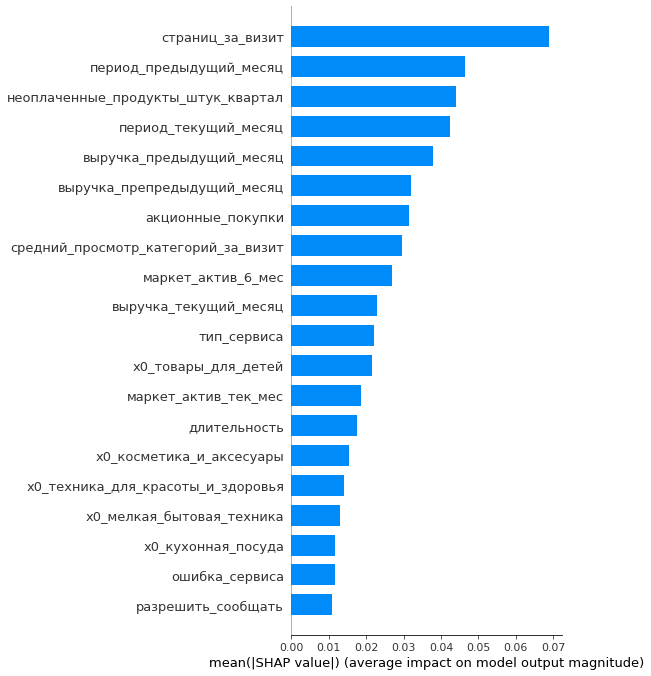

In [87]:
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar",
                  feature_names=features_out)

# Вывод
Для итоговой модели,которая была выбрана,наиболее важными признаками является:
- кол-во страниц за визит;
- среднее кол-во просмотренных категорий за визит;
- проведенное в предыдущем месяце время;
- кол-во неоплаченных товаров в корзине за квартал;
- доля акционных покупок.

Наименее важны оказались следующие признаки:
- выручка за текущий месяц;
- популярные категории (кроме бытовой техники и техники для красоты);
- разрешение на отправку рекламынх рассылок;
- тип сервиса;
- выручки за предыдущий месяц;
- ошибки сервиса;
- длительность.

Для принятия каких-либо решений от бизнеса стоит обращать внимание на поведение клиента на сайте, стоит увеличивать вовлеченность клиентов: как хорошо им предлагается новые категории товаров, например, на основе их  интересов, проведение скидок для различных типов покупателей.

## Шаг 8. Общий вывод

Цель исследования:  разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Для выполнения поставленной цели были решены ряд задач.
1. Загрузка данных. 
Было загружено 4 файла. Было установлено, что необходимо было изменить названия столбцов (но оставен был русский регистр). Необходимо было установить наличество дубликатов и пропусков.

2. Предобработка данных

 Во всех файлах была проведена редакция названия колон. Во всех файлах были проверены данные на уникальноть, если наблюдались несоответсвия - они исправлялись. Всех файлах отсутствуют пропуски. Во всех данных дубликаты отсутствовали.

3. Исследовательский анализ данных
В датафрейме market_file:
- покупательская_активность снизилась у 38% клиентов. это плохой показатель, необходимо выяснить причину.
- тип_сервиса стандартный у 71% клиентов. Премиумом ползуются 29%. Хорощий показатель.
- разрешить_сообщать. 74% клиентов соглашаются на рассылку товаров. Возможно такой большой процент вызван из-за предоставления, например, скидки.
- Распределение популярных категорий выглядит следующим образом:
  - товары для детей: 25%
  - товары для дома 19%
  - косметика и аксессуары 17%
  - техника для красоты и здоровья 14%
  - мелкая бытовая техника 13%
  - кухонная посуда 11%
- Маркетинговая_активность в текущий месяц у большинства клиентов составляет 4 штуки.
- Исследовав данные по маркетинговой активности за 6 месяцев, видно, что покупательская активность держится лучше у тех, кто переключается на маркетинговые активы, развивается более 4-х раз за полгода, так же как и на коробках импульсов тех, кто менее 2,4-х раз попадает на маркетинговую коммуникацию. Если глянуть список, то видно, что почти все они менее активные покупатели.
- По данным столбца длительности заметно, что то, как давно клиент зарегестрирован, не говорит о том, что он будет более активным. 
- По данным акционных покупок замечено, что они приобретают товары невзирая на скидки, сохраняя свою активность. А вот те, кто покупает со скидками, не особо активны.
- По данным неоплаченных товаров в корзине за квартал, видно, что менее заинтерсованных покупателей в корзине лежат гораздо больше товаров. Активная аудитория имеет не более 5 товаров. Неактивная же любит положить в корзину побольше
- Сайт часто падает, люди ловят по 2-4 ошибки выезда из сервиса.
- Про страницы: чем меньше категорий посещаемости клиентов, тем больше вероятность, что он не будет закупаться постоянно.

В датафрейме market_money:
- Распределение покупок по месяцам одинаковое
- Выручка от месяца к месяцу растет, не снижая активности. 6272769 в препредыдущем; затем 6417996 в предыдущем и выше 6909449 в текущем месяце.
- Есть какой-то клиент, который купил товар более, чем за 100 000.
- Чаще всего клиенты тратят 5 000, а все что меньше 3 500 или больше 6 500 уже выбивается из межквартильного размаха. Был убран 1 выброс, с выручкой более, чем 100 000.

В датафрейме market_time:
- Время посещения для каждого месяца в среднем проводят одинаково.

В датафрейме money:
- Значение прибыли имеет нормальное распределение, на ящике виднеются выбросы, похожи на те, что есть и в датасете выше по выручке.

4. Корреляционный анализ данных

Целевым признак - Покупательская_активность.

Список признаков, которые имеют корреляцию с целевым: 
- Маркет_актив_6_мес, 
- Акционные_покупки, 
- Средний_просмотр_категорий_за_визит, 
- Неоплаченные_продукты_штук_квартал, 
- Страниц_за_визит, 
- Выручка_препредыдущий_месяц, 
- минут_предыдущий_месяц, 
- минут_текущий_месяц.

Среди признаков сильная корреляция: Страниц_за_визит, минут_предыдущий_месяц.

Но значение корреляции меньше 0.9 поэтому не будем удалять признаки.


5. Объеденение таблиц
Датасеты market_file, market_money, market_time были объеденены в один датафрейм.

6. Обучение модели
Наилучшая модель: SVC
Параметры наилучшей модели: 
- C=10.0
- degree=2
- gamma='auto'
- kernel='poly'
- probability=True,
    random_state=42

Метрика, которая будет лучше всего отражать модель, будет  roc-auc. Поскольку она отражает зависимость TPR и FPR, поэтому она всегда даёт адекватную оценку качества модели.Метрика f1 даст низкое качество, если хотя бы одна из его составляющих даёт низкую оценку. Для accuracy характерно общее количество правильных ответов, поэтому она не обращает внимания на то, что модель плохо предсказывает принадлежность к минорным классам. 

Метрика ROC-AUC на тестовой выборке: 0.90. Хороший результат.

7. Анализ важности признаков
Для итоговой модели,которая была выбрана,наиболее важными признаками является:
- кол-во страниц за визит;
- среднее кол-во просмотренных категорий за визит;
- проведенное в предыдущем месяце время;
- кол-во неоплаченных товаров в корзине за квартал;
- доля акционных покупок.

Наименее важны оказались следующие признаки:
- выручка за текущий месяц;
- популярные категории (кроме бытовой техники и техники для красоты);
- разрешение на отправку рекламынх рассылок;
- тип сервиса;
- выручки за предыдущий месяц;
- ошибки сервиса;
- длительность.

Для принятия каких-либо решений от бизнеса стоит обращать внимание на поведение клиента на сайте, стоит увеличивать вовлеченность клиентов: как хорошо им предлагается новые категории товаров, например, на основе их  интересов, проведение скидок для различных типов покупателей.